In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.pyplot import subplots
import os

## 1 - Data

### 1.1 Data Loading

In [70]:
stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)
stk_data['PRC'] = abs(stk_data['PRC'])
stk_data['MktCap_Mon'] = stk_data['PRC']*stk_data['SHROUT'] 
stk_data['date'] = pd.to_datetime(stk_data['date'], format='%Y-%m-%d')
stk_data['Year'] = stk_data['date'].dt.strftime('%Y')
stk_data['date'] = stk_data['date'].dt.strftime('%Y-%m')

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1026/764027733.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  stk_data = pd.read_csv("Data/Stk_Rets.csv", header=0)


In [71]:
FF_data = pd.read_csv("Data/F&F_Factors.csv")
FF_data.index = FF_data['dateff']
FF_data = FF_data.drop("dateff", axis=1)
FF_data.index = pd.to_datetime(FF_data.index, format="%Y-%m-%d").to_period('M')
FF_data.rename_axis('date', inplace=True)
FF_data = FF_data.drop(FF_data.index[-1])

In [72]:
Acc_Data = pd.read_csv("Data/Acc_Data.csv", header=0)
Acc_Data = Acc_Data.rename(columns={'LPERMNO': 'PERMNO'})
Acc_Data = Acc_Data.rename(columns={'datadate': 'date'})
Acc_Data.drop_duplicates(subset=['PERMNO', 'date'], inplace=True, ignore_index=True)
Acc_Data['date'] = pd.to_datetime(Acc_Data['date'])
Acc_Data['date'] = Acc_Data['date'].dt.year
Acc_Data.sort_values(by=['PERMNO','date'])

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt
86942,12994,1987,INDL,C,D,STD,USD,5.4178,NaN,0.32,5.369,I,LC,10001,1987-06-30
86943,12994,1988,INDL,C,D,STD,USD,5.5565,NaN,0.57,5.512,I,LC,10001,1988-06-30
86944,12994,1989,INDL,C,D,STD,USD,6.3147,NaN,1.21,6.321,I,LC,10001,1989-06-30
86945,12994,1990,INDL,C,D,STD,USD,6.9631,NaN,1.10,7.179,I,LC,10001,1990-06-29
86946,12994,1991,INDL,C,D,STD,USD,7.4390,NaN,1.01,7.982,I,LC,10001,1991-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230069,184996,2019,INDL,C,D,STD,USD,36.5635,14697.0,-4.92,6618.000,A,LC,93436,2019-12-31
230070,184996,2020,INDL,C,D,STD,USD,23.1510,13347.0,0.64,22225.000,A,LC,93436,2020-12-31
230071,184996,2021,INDL,C,D,STD,USD,29.2246,8873.0,4.90,30189.000,A,LC,93436,2021-12-31
230072,184996,2022,INDL,C,D,STD,USD,14.1290,5748.0,3.62,44704.000,A,LC,93436,2022-12-30


# 2 - Strategies Evaluation

## 2.1 Quality Strategy

### 2.1.1 Defining Quality Score

In [73]:
Acc_Data['ROE'] = Acc_Data['epsfi']/Acc_Data['bkvlps']
Acc_Data['DtE_Rat'] = Acc_Data['dt']/Acc_Data['seq']
Acc_Data

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
0,1001,1985,INDL,C,D,STD,USD,3.2633,NaN,0.68,13.014,I,LU,10015,1985-12-31,0.208378,NaN
1,1003,1986,INDL,C,D,STD,USD,2.4842,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236103,347085,2023,INDL,C,D,STD,USD,4.6842,9.844,1.05,144.982,A,LC,21069,2023-02-28,0.224158,0.067898
236104,348615,2023,INDL,C,D,STD,USD,2.9612,11.642,-0.48,97.590,A,LC,23424,2023-12-29,-0.162096,0.119295
236105,348892,2022,INDL,C,D,STD,USD,0.5382,3.503,-2.26,7.883,A,LC,20846,2022-12-30,-4.199182,0.444374
236106,349972,2022,INDL,C,D,STD,USD,2.9319,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.003248


In [74]:
Quality_df_df = Acc_Data
company_years = Quality_df_df.groupby('PERMNO')['date'].nunique()
companies_with_5_years = company_years[company_years >= 5].index
companies_with_5_years

Acc_data_filtered = Acc_Data[Acc_Data['PERMNO'].isin(companies_with_5_years)]
Acc_data_filtered

,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat
1,1003,1986,INDL,C,D,STD,USD,2.4842,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,NaN
5,1003,1990,INDL,C,D,STD,USD,-0.1551,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236085,332115,2022,INDL,C,D,STD,USD,0.9982,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,1.352966
236101,347007,2022,INDL,C,D,STD,USD,-1.0611,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-1.621478
236102,347007,2023,INDL,C,D,STD,USD,-0.8750,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.505446
236106,349972,2022,INDL,C,D,STD,USD,2.9319,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.003248


In [75]:
def calculate_evar(group):
    if len(group) > 4:
        group['EPSg'] = group['epsfi'].pct_change() * 100
        group.loc[4:, 'EVAR'] = group['EPSg'].rolling(window=4).std(ddof=1)
        
    else:
        group['EVAR'] = 0
        
    return group

In [76]:
Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)
Acc_data_filtered

/var/folders/bz/jsngdqs55xxdjx6nm7z430l00000gn/T/ipykernel_1026/3759281452.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  Acc_data_filtered = Acc_data_filtered.groupby('PERMNO').apply(calculate_evar)


,gvkey,date,indfmt,consol,popsrc,datafmt,curcd,bkvlps,dt,epsfi,seq,costat,LINKTYPE,PERMNO,MthCalDt,ROE,DtE_Rat,EPSg,EVAR
1,1003,1986,INDL,C,D,STD,USD,2.4842,NaN,0.09,6.665,I,LU,10031,1986-01-31,0.036229,NaN,NaN,NaN
2,1003,1987,INDL,C,D,STD,USD,2.7797,NaN,0.30,7.458,I,LU,10031,1987-01-30,0.107925,NaN,233.333333,NaN
3,1003,1988,INDL,C,D,STD,USD,2.8487,NaN,0.07,7.643,I,LU,10031,1988-01-29,0.024573,NaN,-76.666667,NaN
4,1003,1989,INDL,C,D,STD,USD,-0.0723,NaN,-2.92,-0.194,I,LU,10031,1989-01-31,40.387275,NaN,-4271.428571,NaN
5,1003,1990,INDL,C,D,STD,USD,-0.1551,NaN,-0.08,-0.416,I,LU,10031,NaN,0.515796,NaN,-97.260274,2150.937866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236085,332115,2022,INDL,C,D,STD,USD,0.9982,48.815,-1.08,36.080,A,LC,80577,2022-12-30,-1.081948,1.352966,12.500000,77.771864
236101,347007,2022,INDL,C,D,STD,USD,-1.0611,725.331,-1.04,-447.327,A,LC,15533,2022-12-30,0.980115,-1.621478,16.853933,30.756963
236102,347007,2023,INDL,C,D,STD,USD,-0.8750,883.677,-1.15,-586.987,A,LC,15533,2023-12-29,1.314286,-1.505446,10.576923,31.164466
236106,349972,2022,INDL,C,D,STD,USD,2.9319,0.080,-1.73,24.631,A,LC,15642,2022-12-30,-0.590061,0.003248,-57.598039,109.489869


In [77]:
def Q_score(df):
    mean_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].mean()
    std_per_year = df.groupby('date')[['ROE', 'DtE_Rat', 'EVAR']].std()

    df = df.merge(mean_per_year, on='date', suffixes=('', '_mean'))
    df = df.merge(std_per_year, on='date', suffixes=('', '_std'))

    df['ROE Z-Score'] = (df['ROE'] - df['ROE_mean']) / df['ROE_std']
    df['DtE_Rat Z-Score'] = (df['DtE_Rat'] - df['DtE_Rat_mean']) / df['DtE_Rat_std']
    df['Evar Z-Score'] = (df['EVAR'] - df['EVAR_mean']) / df['EVAR_std']

    df['Quality Z-Score'] = (df['ROE Z-Score']+df['DtE_Rat Z-Score']+df['Evar Z-Score'])/3
    
    missing_roe = df['ROE'].isnull()
    df.loc[missing_roe, 'Quality Z-Score'] = np.nan
    
    missing_dte = df['DtE_Rat'].isnull()
    case_2 = missing_dte & ~missing_roe
    df.loc[case_2, 'Quality Z-Score'] = (df['ROE Z-Score'] + df['Evar Z-Score']) / 2
    
    missing_evar = df['EVAR'].isnull()
    case_3 = missing_evar & ~missing_roe
    df.loc[case_3, 'Quality Z-Score'] = (df['ROE Z-Score'] + df['DtE_Rat Z-Score']) / 2
    
    case_4 = missing_dte & missing_evar & ~missing_roe
    df.loc[case_4, 'Quality Z-Score'] = np.nan
    
    case_5 = missing_roe & missing_dte & missing_evar
    df.loc[case_5, 'Quality Z-Score'] = np.nan

    df['Quality Score'] = df['Quality Z-Score'].apply(lambda x: (1 + x) if x >= 0 else (1 - x)**(-1) if not np.isnan(x) else np.nan)
    
    return df

In [78]:
Quality_df = Acc_data_filtered
Quality_df = Q_score(Quality_df)
Quality_df['date'] = pd.to_datetime(Quality_df['date'], format= "%Y")
Quality_df['date'] = Quality_df['date'].dt.strftime('%Y')
Quality_df = Quality_df[['date', 'PERMNO', 'Quality Score']]
Quality_df.rename(columns={'date': 'Year'}, inplace=True)
Quality_df

,Year,PERMNO,Quality Score
0,1986,10031,NaN
1,1986,54594,NaN
2,1986,10066,NaN
3,1986,10074,NaN
4,1986,10082,NaN
...,...,...,...
215262,2023,15920,0.919038
215263,2023,17676,0.986612
215264,2023,18144,0.935711
215265,2023,14615,0.813274


Now, we are going to merge the 2 datasets:

* Monthly stock returns (with montly market cap): "stk_data"
* Yearly deciles sorting: "Quality_df"

In [79]:
merged_df = pd.merge(stk_data, Quality_df, on=['Year', 'PERMNO'], how='left')
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df.drop(columns=['Year'], inplace=True)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,MktCap_Mon,Quality Score
24,10001,1992-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,13.75000,-0.051724,1075.0,1.478125e+04,0.907443
25,10001,1992-02,11.0,3.0,4920.0,GREAT FALLS GAS CO,11.00000,-0.200000,1075.0,1.182500e+04,0.907443
26,10001,1992-03,11.0,3.0,4920.0,GREAT FALLS GAS CO,11.75000,0.081818,1075.0,1.263125e+04,0.907443
27,10001,1992-04,11.0,3.0,4920.0,GREAT FALLS GAS CO,11.87500,0.010638,1075.0,1.276562e+04,0.907443
28,10001,1992-05,11.0,3.0,4920.0,GREAT FALLS GAS CO,12.00000,0.010526,1075.0,1.290000e+04,0.907443
...,...,...,...,...,...,...,...,...,...,...,...
3154219,93436,2023-08,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,8.191443e+08,0.987993
3154220,93436,2023-09,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,7.954494e+08,0.987993
3154221,93436,2023-10,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,6.384545e+08,0.987993
3154222,93436,2023-11,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,7.631954e+08,0.987993


Now we perform the basic data cleaning suggested by Prof. Smajlbegovic in the weekly assignment n.2.
* Selecting only common stocks
* Selecting only stocks listed on the NYSE, NASDAQ or AMEX
* Selecting only non financial firms

**Note:** observations that do not ahve returns data are removed from the dataset.

In [80]:
merged_df = merged_df[(merged_df['SHRCD'] == 10) | (merged_df['SHRCD'] == 11)] # Selecting only common stock
merged_df = merged_df[(merged_df['EXCHCD'] == 1) | (merged_df['EXCHCD'] == 2) | (merged_df['EXCHCD'] == 3)] # Selecting only stocks listed on the NYSE, NASDAQ or AMEX
merged_df['SICCD'] = pd.to_numeric(merged_df['SICCD'], errors='coerce')
merged_df = merged_df[(merged_df['SICCD'] < 6000) | (merged_df['SICCD'] > 6999)]

In [81]:
merged_df['RET'] = pd.to_numeric(merged_df['RET'], errors='coerce')
merged_df = merged_df.dropna(subset=['RET'])
merged_df['date'] = pd.to_datetime(stk_data['date'], format='%Y-%m-%d')
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,MktCap_Mon,Quality Score
24,10001,1992-01-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,13.75000,-0.051724,1075.0,1.478125e+04,0.907443
25,10001,1992-02-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,11.00000,-0.200000,1075.0,1.182500e+04,0.907443
26,10001,1992-03-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,11.75000,0.081818,1075.0,1.263125e+04,0.907443
27,10001,1992-04-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,11.87500,0.010638,1075.0,1.276562e+04,0.907443
28,10001,1992-05-01,11.0,3.0,4920.0,GREAT FALLS GAS CO,12.00000,0.010526,1075.0,1.290000e+04,0.907443
...,...,...,...,...,...,...,...,...,...,...,...
3154219,93436,NaT,11.0,3.0,9999.0,TESLA INC,258.07999,-0.034962,3173994.0,8.191443e+08,0.987993
3154220,93436,NaT,11.0,3.0,9999.0,TESLA INC,250.22000,-0.030456,3179000.0,7.954494e+08,0.987993
3154221,93436,NaT,11.0,3.0,9999.0,TESLA INC,200.84000,-0.197346,3178921.0,6.384545e+08,0.987993
3154222,93436,NaT,11.0,3.0,9999.0,TESLA INC,240.08000,0.195379,3178921.0,7.631954e+08,0.987993


### 2.1.2 Deciles Portfolios Sorting

In [82]:
merged_df = merged_df.sort_values(by='Quality Score', ascending=False)
merged_df.dropna(subset=['Quality Score'], inplace=True)
merged_df['decile_Q'] = merged_df.groupby(['date'])['Quality Score'].transform(lambda x: pd.qcut(x, 10, labels=False) + 1)
merged_df

,PERMNO,date,SHRCD,EXCHCD,SICCD,COMNAM,PRC,RET,SHROUT,MktCap_Mon,Quality Score,decile_Q
2923432,91349,2004-01-01,11.0,3.0,7997.0,TOWN SPORTS INTL HOLDINGS INC,22.79000,0.045413,26068.0,594089.72000,33.579846,10.0
2923431,91349,2003-12-01,11.0,3.0,7997.0,TOWN SPORTS INTL HOLDINGS INC,21.80000,0.109980,26068.0,568282.40000,33.579846,10.0
2923433,91349,2004-02-01,11.0,3.0,7997.0,TOWN SPORTS INTL HOLDINGS INC,20.10000,-0.118034,26118.0,524971.80000,33.579846,10.0
2923434,91349,2004-03-01,11.0,3.0,7997.0,TOWN SPORTS INTL HOLDINGS INC,19.32000,-0.038806,26209.0,506357.88000,33.579846,10.0
2923435,91349,2004-04-01,11.0,3.0,7997.0,TOWN SPORTS INTL HOLDINGS INC,17.03000,-0.118530,26209.0,446339.27000,33.579846,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72433,10878,1993-07-01,11.0,3.0,4810.0,COMMUNICATIONS WORLD INTL INC,1.12500,0.440000,1546.0,1739.25000,0.031300,1.0
72432,10878,1993-06-01,11.0,3.0,4810.0,COMMUNICATIONS WORLD INTL INC,0.78125,0.020408,1546.0,1207.81250,0.031300,1.0
72431,10878,1993-05-01,11.0,3.0,4810.0,COMMUNICATIONS WORLD INTL INC,0.76563,-0.125000,1546.0,1183.66398,0.031300,1.0
72430,10878,1993-04-01,11.0,3.0,4810.0,COMMUNICATIONS WORLD INTL INC,0.87500,-0.461538,1546.0,1352.75000,0.031300,1.0


### 2.1.3 Deciles Portfolios Returns

In [83]:
def compute_deciles_port(merged_df):
    copy = merged_df.copy()
    
    grouped = copy.groupby(['date', 'decile_Q'])

    copy['Total_MktCap_Month_Decile'] = grouped['MktCap_Mon'].transform('sum')
    copy['Weight_Decile'] = copy['MktCap_Mon'] / copy['Total_MktCap_Month_Decile']
    copy['Weighted_RET_Decile'] = copy['RET'] * copy['Weight_Decile']


    portfolio_df = pd.pivot_table(copy, values='Weighted_RET_Decile', index='date', columns='decile_Q', aggfunc='sum')
    portfolio_df.columns = ['P' + str(col) for col in portfolio_df.columns]
    
    return portfolio_df

In [84]:
portfolio_df = compute_deciles_port(merged_df)
portfolio_df['H-L'] = portfolio_df['P10.0'] - portfolio_df['P1.0']
portfolio_df.index = pd.to_datetime(portfolio_df.index, format="%Y-%m-%d").to_period('M')
portfolio_df

,P1.0,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,P10.0,H-L
date,,,,,,,,,,,
1990-01,0.000531,-0.039709,0.011798,-0.009270,0.013224,0.029871,0.048991,0.027081,0.030161,0.027982,0.027452
1990-02,0.021375,0.010080,-0.002897,-0.035274,0.004448,0.024734,0.063270,0.034085,0.026992,0.006399,-0.014976
1990-03,0.049889,0.039229,0.043932,0.068639,0.036996,-0.005283,0.011514,0.030398,0.011495,0.041251,-0.008638
1990-04,0.000029,-0.005933,0.012502,-0.038430,0.015787,0.004668,0.063170,-0.007054,0.011808,0.038705,0.038676
1990-05,-0.024431,0.011153,0.041894,-0.017330,0.011196,0.003175,-0.005060,0.035653,0.019851,0.046698,0.071129
...,...,...,...,...,...,...,...,...,...,...,...
2023-08,0.018429,0.005152,-0.007359,-0.014314,0.016596,0.043864,0.004989,0.021059,0.045648,0.004715,-0.013715
2023-09,0.001348,0.015052,0.022202,-0.028719,0.016859,0.001103,0.030472,0.048347,0.025960,0.012816,0.011468
2023-10,0.006561,-0.004316,0.011718,-0.017448,0.010285,-0.000606,-0.034997,0.014105,0.028270,0.012132,0.005571


### 2.1.4 Returns Analysis

After forming the portfolios, we first compute excess returns (by subtracting the rf column of the FF data) and then merge the two dataframes in a single one.

In [85]:
rf = FF_data['rf']
portfolio_df = portfolio_df.sub(rf, axis=0)
portfolio_df

Quality_FF = pd.concat([portfolio_df, FF_data], axis=1)
Quality_FF

,P1.0,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,P10.0,H-L,mktrf,smb,hml,rmw,cma,rf,umd
date,,,,,,,,,,,,,,,,,,
1990-01,-0.005169,-0.045409,0.006098,-0.014970,0.007524,0.024171,0.043291,0.021381,0.024461,0.022282,0.021752,-0.0785,-0.0131,0.0085,-0.0117,0.0135,0.0057,-0.0327
1990-02,0.015675,0.004380,-0.008597,-0.040974,-0.001252,0.019034,0.057570,0.028385,0.021292,0.000699,-0.020676,0.0111,0.0117,0.0064,-0.0003,-0.0066,0.0057,-0.0055
1990-03,0.043489,0.032829,0.037532,0.062239,0.030596,-0.011683,0.005114,0.023998,0.005095,0.034851,-0.015038,0.0183,0.0162,-0.0292,0.0204,-0.0102,0.0064,0.0180
1990-04,-0.006871,-0.012833,0.005602,-0.045330,0.008887,-0.002232,0.056270,-0.013954,0.004908,0.031805,0.031776,-0.0336,-0.0033,-0.0259,0.0178,-0.0098,0.0069,0.0239
1990-05,-0.031231,0.004353,0.035094,-0.024130,0.004396,-0.003625,-0.011860,0.028853,0.013051,0.039898,0.064329,0.0842,-0.0235,-0.0383,0.0157,-0.0168,0.0068,0.0303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08,0.013929,0.000652,-0.011859,-0.018814,0.012096,0.039364,0.000489,0.016559,0.041148,0.000215,-0.018215,-0.0239,-0.0365,-0.0106,0.0343,-0.0237,0.0045,0.0377
2023-09,-0.002952,0.010752,0.017902,-0.033019,0.012559,-0.003197,0.026172,0.044047,0.021660,0.008516,0.007168,-0.0524,-0.0180,0.0152,0.0186,-0.0083,0.0043,0.0026
2023-10,0.001861,-0.009016,0.007018,-0.022148,0.005585,-0.005306,-0.039697,0.009405,0.023570,0.007432,0.000871,-0.0319,-0.0404,0.0019,0.0246,-0.0066,0.0047,0.0173


Plotting the cumulative returns of long-short quality factor vs. market benchmark:

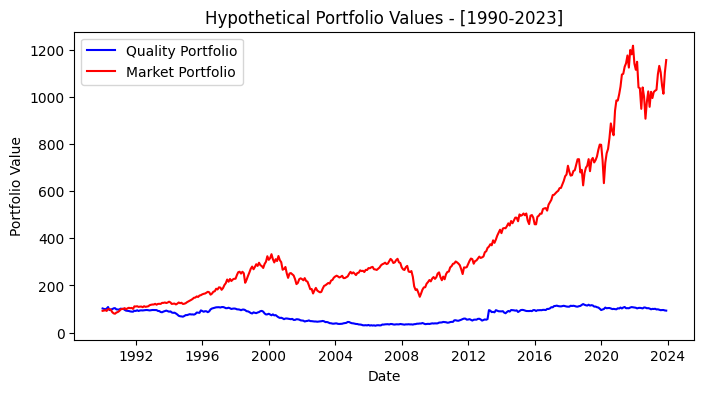

In [131]:
cumulative_returns1 = (1 + Quality_FF['H-L']).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']).cumprod()

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Hypothetical Portfolio Values - [1990-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

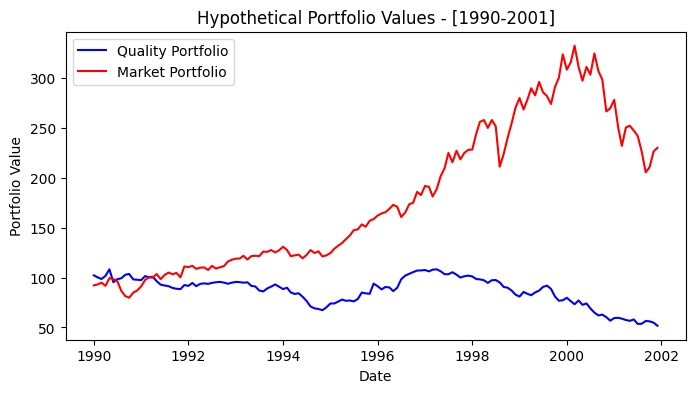

In [130]:
cumulative_returns1 = (1 + Quality_FF['H-L']['1990':'2001']).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']['1990':'2001']).cumprod()

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Hypothetical Portfolio Values - [1990-2001]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

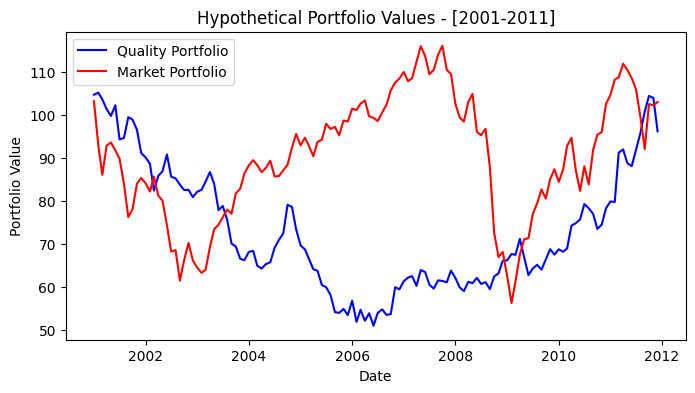

In [128]:
cumulative_returns1 = (1 + Quality_FF['H-L']['2001':'2011']).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']['2001':'2011']).cumprod()

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Hypothetical Portfolio Values - [2001-2011]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

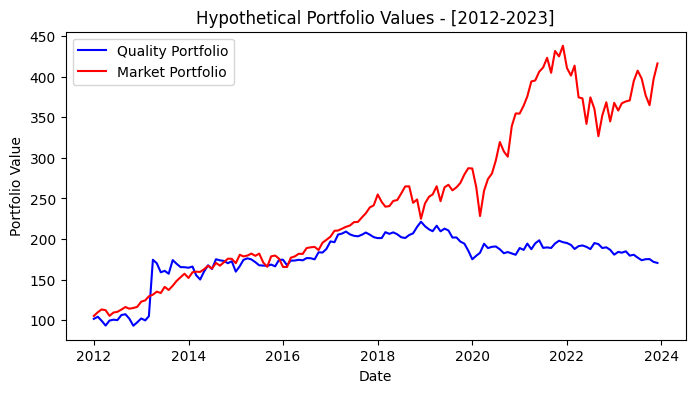

In [129]:
cumulative_returns1 = (1 + Quality_FF['H-L']['2012':]).cumprod()
cumulative_returns2 = (1 + Quality_FF['mktrf']['2012':]).cumprod()

cumulative_returns1.index = cumulative_returns1.index.to_timestamp()
cumulative_returns2.index = cumulative_returns2.index.to_timestamp()

initial_value = 100

portfolio_value1 = cumulative_returns1 * initial_value
portfolio_value2 = cumulative_returns2 * initial_value

plt.figure(figsize=(8, 4))
plt.plot(portfolio_value1, color='blue', linestyle='-', label='Quality Portfolio')
plt.plot(portfolio_value2, color='red', linestyle='-', label='Market Portfolio')
plt.title('Hypothetical Portfolio Values - [2012-2023]')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

### 2.1.5 Regressions

**1) CAPM**

In [119]:
factors_CAPM = Quality_FF['mktrf']

regression_results_CAPM = pd.DataFrame(index=portfolio_df.columns, columns=['Alpha CAPM', 'Mkt-RF'])

for portfolio in portfolio_df.columns:
    portfolio_returns = portfolio_df[portfolio]
    
    X_CAPM = sm.add_constant(factors_CAPM)
    
    model = sm.OLS(portfolio_returns, X_CAPM)
    results = model.fit()
    
    regression_results_CAPM.loc[portfolio, 'Alpha CAPM'] = results.params[0] 
    regression_results_CAPM.loc[portfolio, 'Mkt-RF'] = results.params[1]

regression_results_CAPM = regression_results_CAPM.T
regression_results_CAPM

,P1.0,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,P10.0,H-L
Alpha CAPM,0.0178,0.011667,0.013071,0.018166,0.017995,0.018635,0.022285,0.022037,0.019422,0.020795,0.000843
Mkt-RF,0.006902,-0.005176,-0.057918,0.022144,-0.052804,0.002711,-0.024479,0.000945,-0.028006,0.001667,-0.003268


**2) FF-3**

In [120]:
factors_FF3 = Quality_FF[['mktrf', 'smb', 'hml']]

regression_results_FF3 = pd.DataFrame(index=portfolio_df.columns, columns=['Alpha FF3', 'Mkt-RF'])

for portfolio in portfolio_df.columns:
    portfolio_returns = portfolio_df[portfolio]
    
    X_FF3 = sm.add_constant(factors_FF3)
    
    model = sm.OLS(portfolio_returns, X_FF3)
    results = model.fit()
    
    regression_results_FF3.loc[portfolio, 'Alpha FF3'] = results.params[0] 
    regression_results_FF3.loc[portfolio, 'Mkt-RF'] = results.params[1]

regression_results_FF3 = regression_results_FF3.T
regression_results_FF3

,P1.0,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,P10.0,H-L
Alpha FF3,0.01783,0.011523,0.013079,0.018195,0.017928,0.01873,0.022389,0.022039,0.019369,0.020778,0.000797
Mkt-RF,0.002744,0.001879,-0.055538,0.03095,-0.053727,0.00296,-0.030799,-0.014695,-0.016644,0.002723,0.001242


**3) FF-5**

In [121]:
factors_FF5 = Quality_FF[['mktrf', 'smb', 'hml', 'rmw', 'cma']]

regression_results_FF5 = pd.DataFrame(index=portfolio_df.columns, columns=['Alpha FF5', 'Mkt-RF'])

for portfolio in portfolio_df.columns:
    portfolio_returns = portfolio_df[portfolio]
    
    X_FF5 = sm.add_constant(factors_FF5)
    
    model = sm.OLS(portfolio_returns, X_FF5)
    results = model.fit()
    
    regression_results_FF5.loc[portfolio, 'Alpha FF5'] = results.params[0] 
    regression_results_FF5.loc[portfolio, 'Mkt-RF'] = results.params[1]

regression_results_FF5 = regression_results_FF5.T
regression_results_FF5

,P1.0,P2.0,P3.0,P4.0,P5.0,P6.0,P7.0,P8.0,P9.0,P10.0,H-L
Alpha FF5,0.017752,0.011093,0.013278,0.018126,0.017862,0.018456,0.022761,0.021619,0.019262,0.020338,0.000424
Mkt-RF,0.006056,0.01615,-0.068797,0.036031,-0.050089,0.011824,-0.042244,-0.001346,-0.007742,0.024945,0.02074
